# Исходные данные

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Цель проекта

Используя исторические данные, построить модель машинного обучения, которая будет прогнозировать вероятность ухода клиента из банка.

**Критерии**
* Значение F1-меры должно быть предельно большим, не менее 0,59
* F1-мера должна быть не ниже пороговой как на валидационной, так и на тестовой выборке

## Подготовка данных

### Установка модулей и импорт библиотек

In [1]:
# !pip install -U imbalanced-learn

In [2]:
# !pip install scikit-learn==1.1.3

In [3]:
import pandas as pd
import numpy as np
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_curve,
    roc_auc_score
)

# Cэмплинг
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

RND_ST = 12345

### Загрузка данных

Загрузим CSV-файл и ознакомимся с данными:

In [4]:
df = pd.read_csv('datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В наборе данных 10000 объектов с 14-ю признаками:

1. `RowNumber` — индекс строки в данных
2. `CustomerId` — уникальный идентификатор клиента
3. `Surname` — фамилия
4. `CreditScore` — кредитный рейтинг
5. `Geography` — страна проживания
6. `Gender` — пол
7. `Age` — возраст
8. `Tenure` — сколько лет человек является клиентом банка
9. `Balance` — баланс на счёте
10. `NumOfProducts` — количество продуктов банка, используемых клиентом
11. `HasCrCard` — наличие кредитной карты
12. `IsActiveMember` — активность клиента
13. `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

14. `Exited` — факт ухода клиента

### Обработка дубликатов и пропусков

Проверим данные на наличие явных дубликатов:

In [5]:
df.duplicated().sum()

0

Проверим данные на наличие пропущенных значений: 

In [6]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В столбце `Tenure` 909 пропусков. Этот около 10% от всего набора данных, поэтому попробуем сохранить объекты, заполнив пропуски подходящими значениями.

Рассмотрим статистики столбца `Tenure`:

In [7]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

Показатель первого квартиля (Q1) — 2 года, медианное значение (Q2) — 5 лет, 3-й квартиль (Q3) — 7 лет.

Так как во всём столбце данные целочисленные, то приведём его к типу `int`, а пропуски заполним случайными значениями из промежутка от 2-х до 7-ми лет:

In [8]:
df['Tenure'].fillna(randint(2, 7), inplace=True)
df['Tenure'] = df['Tenure'].astype(int)

# Проверка
print("Пропусков:", df['Tenure'].isna().sum())
print("Тип данных:", df['Tenure'].dtype)

Пропусков: 0
Тип данных: int64


### Приведение типов

Так как в сотолбцах `Balance` и `EstimatedSalary` десятичная часть значений имеет малый вес, округлим её и приведём столбец к типу `int` для снижения вычислительной нагрузки в будущем:

In [9]:
df[['Balance', 'EstimatedSalary']] = (df[['Balance', 'EstimatedSalary']]).round().astype(int)

display(df.dtypes)
df.head(3)

RowNumber           int64
CustomerId          int64
Surname            object
CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance             int64
NumOfProducts       int64
HasCrCard           int64
IsActiveMember      int64
EstimatedSalary     int64
Exited              int64
dtype: object

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
1,2,15647311,Hill,608,Spain,Female,41,1,83808,1,0,1,112543,0
2,3,15619304,Onio,502,France,Female,42,8,159661,3,1,0,113932,1


### Итоги этапа
* Данные и библиотеки, необходимые для работы, загружены
* Пропуски и дубликаты обработаны
* Типы данных приведены в соответствие с задачей

## Исследование задачи

### Выделение релевантных признаков
В датафрейме есть столбцы, которые не оказывают влияния на целевой признак:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия

Перенесём данные в новый датафрейм для машинного обучения `ml_df` без этих столбцов:

In [10]:
ml_df = df.drop(['RowNumber','CustomerId', 'Surname'], axis=1 )

print("Shape:", ml_df.shape, sep="")
ml_df.head(1)

Shape:(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,101349,1


Количество признаков сократилось до 11-ти, количество наблюдений осталось неизменным. Перенос выполнен корректно.

Проверим уникальныe значения в столбцах, в которых хранятся категориальные признаки:
* `Geography` — страна проживания
* `Gender` — пол

In [11]:
# Страны проживания
list(ml_df['Geography'].unique())

['France', 'Spain', 'Germany']

In [12]:
# Пол клиента
list(ml_df['Gender'].unique())

['Female', 'Male']

Проверим с помощью визуализации, не коррелируют ли между собой другие числовые признаки:

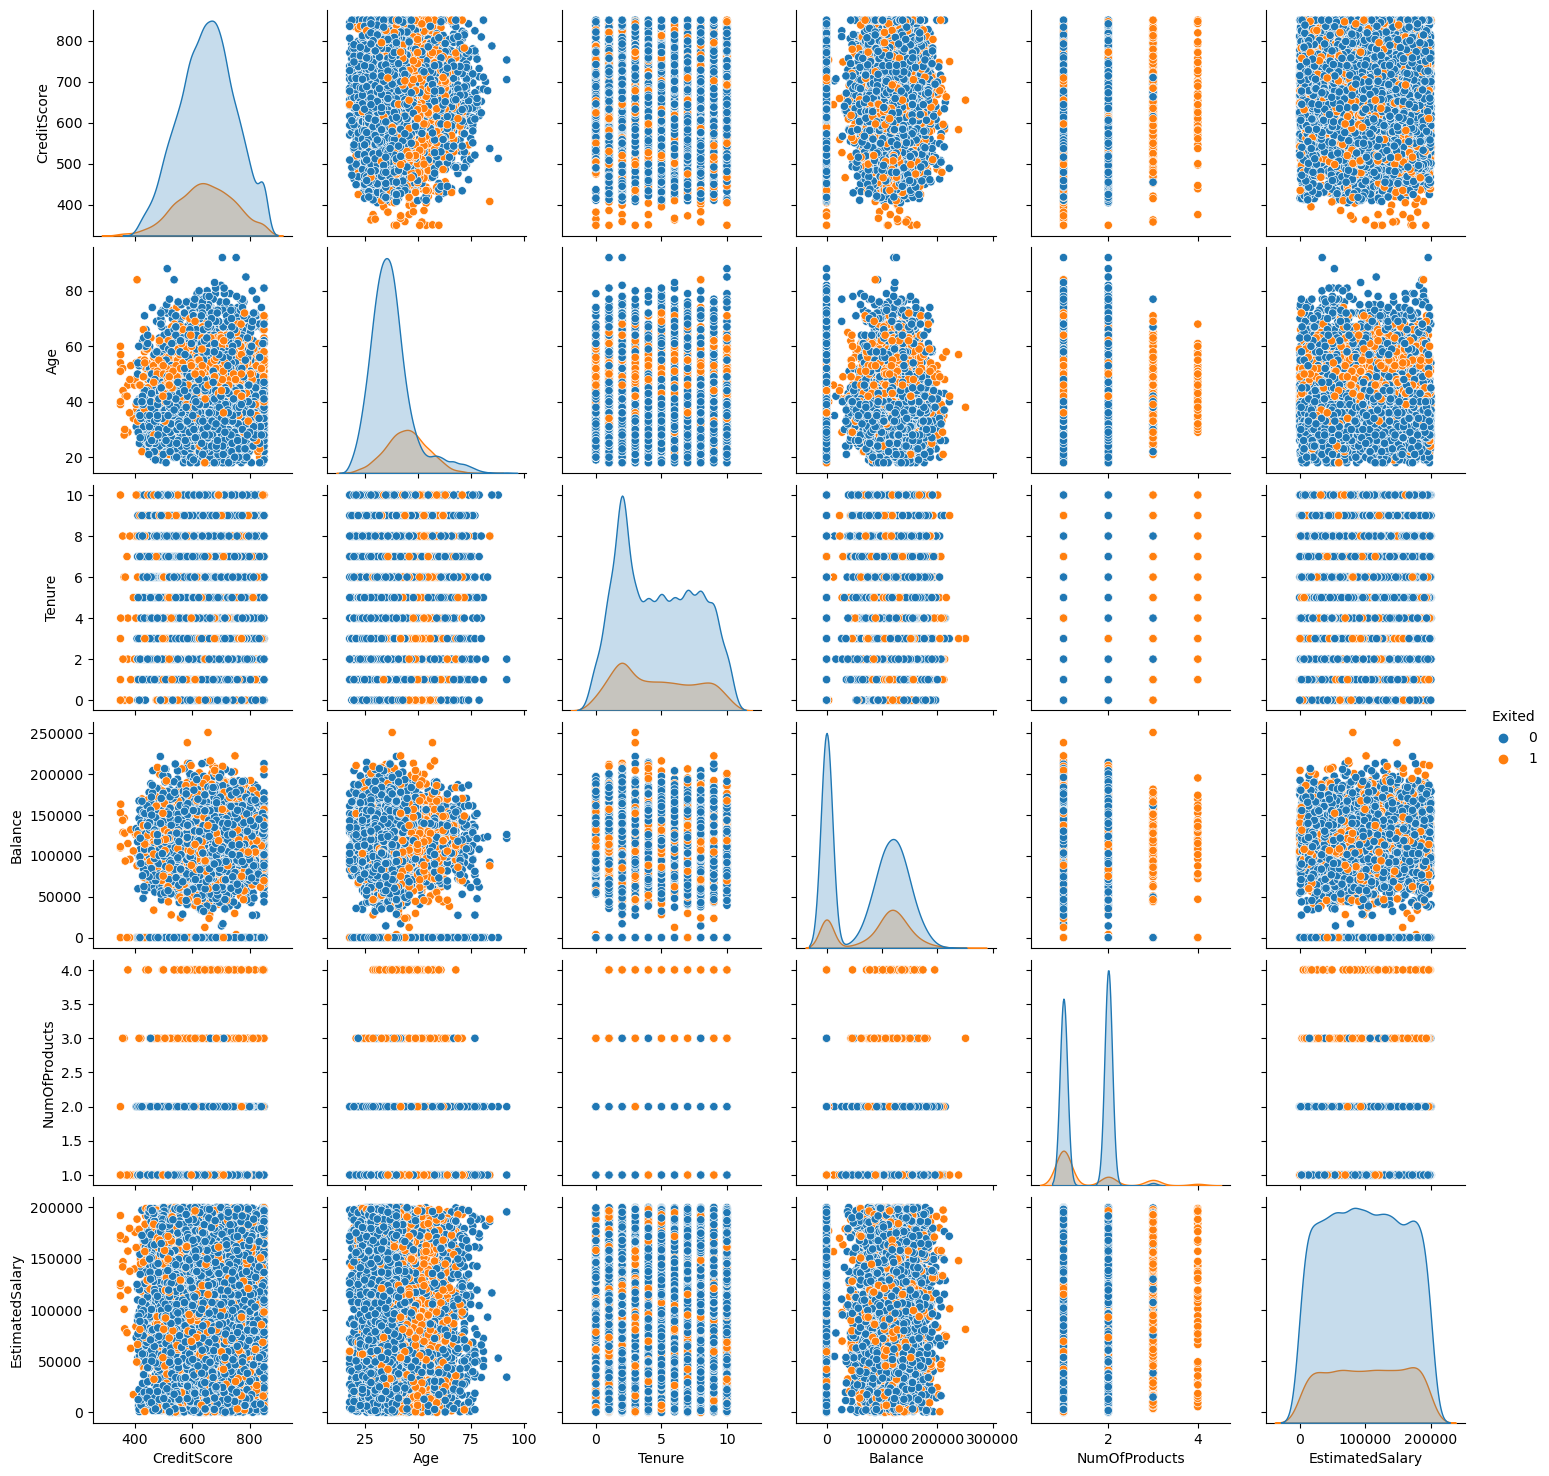

In [13]:
sns.pairplot(ml_df[['CreditScore', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'EstimatedSalary', 'Exited']],
             hue ='Exited');

Так как ни один из графиков не выглядит как линейная функция, признаки не коррелируют явно. Следовательно, данные готовы для следующего шага.

### Разделение на выборки


Выделим характеристики модели и целевой признак:

In [14]:
features = ml_df.drop('Exited', axis = 1)
target = ml_df['Exited']

Так как скрытая тестовая выборка в задаче отсутствует, разобъём данные в соотношении **3:1:1**
* Обучающая — 60%
* Валидационная — 20%
* Тестовая — 20%

In [15]:
# Отделяем валидационную + тестовую (40% от всех данных)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features,
                                                                                        target,
                                                                                        test_size=0.4,
                                                                                        random_state=12345)
# Проверка размерностей
print("Features shape:", features_train.shape)
print("Validation + Test shape:", features_valid_test.shape)

Features shape: (6000, 10)
Validation + Test shape: (4000, 10)


In [16]:
# Делим валидационно-тестовую выборку пополам
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            train_size=0.5,
                                                                            random_state=12345)
# Проверка размерностей
print("Valisation shape:",features_valid.shape)
print("Test shape:", features_test.shape)

Valisation shape: (2000, 10)
Test shape: (2000, 10)


Размерности совпали, разбиение проведено корректно.

### Прямое кодирование категориальных признаков (OHE)

Необходимо закодировать следующие категориальные признаки:
* `Geography` — страна проживания
* `Gender` — пол

In [17]:
# Категориальные признаки для OHE
categorical = ['Geography', 'Gender']
features_train_ohe = features_train[categorical]
features_valid_ohe = features_valid[categorical]
features_test_ohe = features_test[categorical]

features_train_ohe.head(3)

,Geography,Gender
7479,Spain,Male
3411,France,Female
6027,Germany,Male


Обучим энкодер для дальнейшего применения ко всем выборкам:

In [18]:
# drop='first' удаляет первый признак из закодированных
# handle_unknown='ignore'– игнорируется ранее невстречающиеся значения признака
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# Обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe);

Преобразуем тренировочную выборку:

In [19]:
# Закодированные признаки в features_train
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe)

# Незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(features_train_ohe, axis=1)

features_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8,153138,1,1,0,88659,0.0,1.0,1.0
3411,711,37,8,113900,1,0,0,80215,0.0,0.0,0.0
6027,850,44,3,140394,2,0,1,186286,1.0,0.0,1.0


Столбцы `Gender` и `Geography` закодировалиссь успешно.

Сделаем преобразование для валидационной и тестовой выборки:

In [20]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_ohe)
features_valid = features_valid.drop(features_valid_ohe, axis=1)

features_valid.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,585,35,2,0,2,1,0,98621,0.0,0.0,0.0


In [21]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe)
features_test = features_test.drop(features_test_ohe, axis=1)

features_valid.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,585,35,2,0,2,1,0,98621,0.0,0.0,0.0


Кодирование для всех выборок проведено успешно.

### Исследование баланса классов

Проверим в каком соотношении находятся между собой положительные и отрицательные ответы в тренировочной выборке:

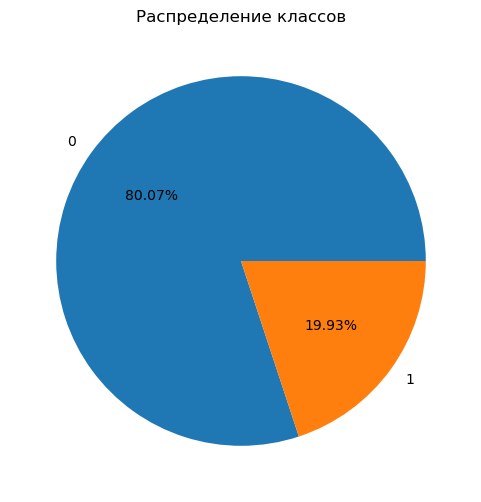

In [22]:
# Счётчик классов
class_counts = target_train.value_counts()

# Визуализация
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%.2f%%')
plt.title('Распределение классов')
plt.show()

Наблюдается значительный дисбаланс — положительных ответов примерно в 4 раза меньше, чем отрицательных.
Вероятно, модель будет склонна предсказывать большинство ответов отрицательными, игнорируя редкие положительные случаи.

С проблемой дисбаланса мы ещё разберёмся на этапе №3, а сейчас продолжим подготовку данных для машинного обучения.

### Масштабирование признаков

Определим размерность числовых признаков с помощью проверки средних значений и стандартного отклонения:

In [23]:
# Список числовых признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Список средних значений
mean_df = ml_df[numeric].mean()
print("Mean list:", list(mean_df))

# Список стандартных отклонений значений
std_df = ml_df[numeric].std()
print("Std list:", list(mean_df))

Mean list: [650.5288, 38.9218, 4.7252, 76485.8931, 1.5302, 100090.2364]
Std list: [650.5288, 38.9218, 4.7252, 76485.8931, 1.5302, 100090.2364]


Наблюдается значительный разборс по масштабу.

Для создания качественной модели стандартизируем признаки с помощью структуры `StandardScaler`. Создадим `scaler` и обучим его на тренировочной выборке:

In [24]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]);

Преобразуем обучающую, валидационную и тестовую выборки функцией `transform()`:

In [25]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Провери преобразования на примере столбцов `EstimatedSalary` и `Balance` у которых были самые большие значения до масштабирования:

In [26]:
# Проверка средних значений
print("Scaled mean:", list(features_train[['EstimatedSalary', 'Balance']].mean()))

# Проверка стандартного отклонения
print("Scaled std:", list(features_train[['EstimatedSalary', 'Balance']].std()))

Scaled mean: [3.315866100213801e-17, 3.907985046680551e-17]
Scaled std: [1.0000833437514458, 1.000083343751434]


В обоих случаях среднее значение максимально близко к нулю, а стандартное отклонение к единице. Следовательно, масштабирование выполнено корректно.

### Метрики для оценки моделей

Создадим функцию, которая будет получать на вход целевые признаки и предсказания, а выводить на экран следующие показатели:

* **Матрица ошибок** *(confusion matrix)* — таблица, показывающая эффективность классификационной модели
* **Доля верных ответов** *(accuracy)* — отношение количества правильных прогнозов к их общему количеству
* **Точность** *(precision)* — доля объектов, названных положительными, при этом действительно являющимися положительными
* **Полнота** *(recall)*— доля найденных объектов положительного класса из всех объектов положительного класса
* **F1-мера** *(F1-score)* — агрегированная метрика, среднее гармоническое *precision* и *recall*

In [27]:
def metrics(target, predictions):
    print("Матрица ошибок:\n", confusion_matrix(target, predictions)) 
    print("Точность:", precision_score(target, predictions))             # precision = TP/(TP+FP)
    print("Полнота:", recall_score(target, predictions))                 # recall = TP/(TP+FN)
    print("F1-мера:", f1_score(target, predictions))                     # F1 = 2*pr*rec/(pr+rec)

### Тренировка и оценка моделей

Проверим, какие метрики мы сможем получить, если будем тренировать 3 разных модели на несбалансированных классах.

#### Дерево решений

In [28]:
best_depth = 0
best_f1 = 0

for depth in range(5, 10):
    model = DecisionTreeClassifier(random_state=RND_ST, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    # Подсчёт F1-меры и сохранение лучшей модели
    f1 = f1_score(target_valid, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        DTC_model = model
    
print("Лучшая DTC-модель\nГлубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая DTC-модель
Глубина: 9
F1-мера:  0.57546


In [29]:
# Проверка всех метрик
metrics(target_valid, DTC_model.predict(features_valid))

Матрица ошибок:
 [[1495   87]
 [ 214  204]]
Точность: 0.7010309278350515
Полнота: 0.4880382775119617
F1-мера: 0.5754583921015515


#### Случайный лес

In [30]:
best_f1 = 0
best_est = 0
best_depth = 0

# Двухуровневый цикл по глубине и количеству деревьев
for est in range(80, 111):
    for depth in range(5, 10):
        model = RandomForestClassifier(random_state=RND_ST,
                                       max_depth=depth,
                                       n_estimators=est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            RFC_model = model
    
print("Лучшая RFC-модель\nКоличество деревьев:", best_est)
print("Глубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая RFC-модель
Количество деревьев: 97
Глубина: 9
F1-мера:  0.57233


In [31]:
metrics(target_valid, RFC_model.predict(features_valid))

Матрица ошибок:
 [[1546   36]
 [ 236  182]]
Точность: 0.8348623853211009
Полнота: 0.4354066985645933
F1-мера: 0.5723270440251572


#### Логистическая регрессия

In [32]:
best_f1 = 0
best_solver = ''
best_iter = 0
solvers = ['liblinear', 'lbfgs',  'sag', 'newton-cg']


for solver in solvers:
    for i in range(50, 121, 10):
        model = LogisticRegression(random_state=RND_ST,
                                   solver=solver,
                                   max_iter = i)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_solver = solver
            best_iter = i
            LR_model = model
    
print("Лучшая LR-модель\nSolver:", best_solver)
print("Итераций:", best_iter)
print("F1-мера: ", round(best_f1, 5))

Лучшая LR-модель
Solver: liblinear
Итераций: 50
F1-мера:  0.3367


In [33]:
metrics(target_valid, LR_model.predict(features_valid))

Матрица ошибок:
 [[1506   76]
 [ 318  100]]
Точность: 0.5681818181818182
Полнота: 0.23923444976076555
F1-мера: 0.33670033670033667


###  Итоги этапа

На несбалансированных классах:
* **Дерево решений** показывает самую высокую **полноту**, что говорит о склонности модели обнаруживать больше положительных ответов и чаще совершать ошибки первого типа (FP)


* **Случайный лес** является лидером среди изученных моделей по 3-м метрикам:
    * **Точность** — говорит о меньшем количестве ошибок первого типа (FP) при классификации
    * **F1-мера** — отражает более высоку сбалансированность между точностью и полнотой по сравнению с другими моделями


* **Логичстическая регрессия** показала самые низкие результаты по **F1-мере**, **точности** **полноте**. У данной модели самый высокий показатель ошибок второго типа (FN)

---

*Для того, чтобы понять, какая модель сможеть показать наилучшее качество и достичь заданной F1-меры 0,59, необходимо справиться с дисбалансом классов.*

## Борьба с дисбалансом

Так как мы уже давным давно всё могли забыть, ещё раз посмотрим на пропорции классов, которые находятся в исходных данных:

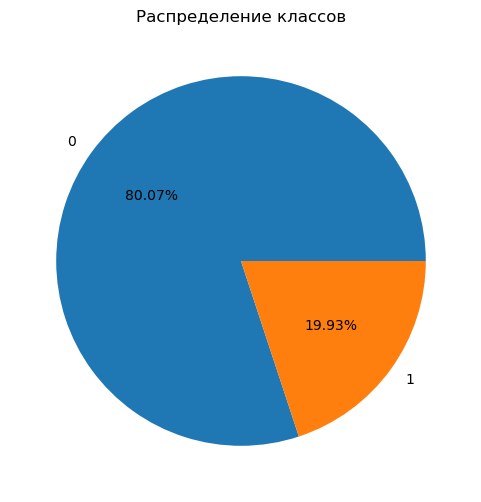

In [34]:
# Счётчик классов
class_counts = target_train.value_counts()

# Визуализация
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%.2f%%')
plt.title('Распределение классов')
plt.show()

Количество отрицательных ответов примерно в 4 раза больше количества положительных. Чтобы повысить точность модели, необходимо найти решение для того, чтобы эти классы сбалансировать. Начнём с самого простого способа.

### Даунсэмплинг

Уберём из тренировочной выборки часть объетов с отрицательными ответами, чтобы сделать размеры классов одинаковыми:

In [35]:
rus = RandomUnderSampler(random_state=12345)
features_train_downsampled, target_train_downsampled = rus.fit_resample(features_train, target_train)

# проверка
print(f"Несбалансированная выборка:\n{target_train.value_counts()}")
print(f"\nПосле даунсэмплинга:\n{target_train_downsampled.value_counts()}")

Несбалансированная выборка:
Exited
0    4804
1    1196
Name: count, dtype: int64

После даунсэмплинга:
Exited
0    1196
1    1196
Name: count, dtype: int64


Классы сбалансированы, но количество объектов уменьшилось в нескoлько раз. Проверим, как будет вести себя лучшая из предыдущих моделей.

#### DTC-модель

In [36]:
best_depth = 0
best_f1 = 0

for depth in range(5, 10):
    model = DecisionTreeClassifier(random_state=RND_ST, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    predictions = model.predict(features_valid)

    f1 = f1_score(target_valid, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        DTC_model_ds = model
    
print("Лучшая DTC-модель\nГлубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая DTC-модель
Глубина: 5
F1-мера:  0.59312


####  RFC-модель

In [37]:
best_f1 = 0
best_est = 0
best_depth = 0

for est in range(80, 111):
    for depth in range(5, 10):
        model = RandomForestClassifier(random_state=RND_ST,
                                       max_depth=depth,
                                       n_estimators=est)
        model.fit(features_train_downsampled, target_train_downsampled)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            RFC_model_ds = model
    
print("Лучшая RFC-модель\nКоличество деревьев:", best_est)
print("Глубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая RFC-модель
Количество деревьев: 99
Глубина: 6
F1-мера:  0.60019


#### LR-модель 

In [38]:
best_f1 = 0
best_solver = ''
best_iter = 0
solvers = ['liblinear', 'lbfgs',  'sag', 'newton-cg']

for solver in solvers:
    for i in range(50, 121, 10):       
        model = LogisticRegression(random_state=RND_ST,
                                   solver=solver,
                                   max_iter = i)
        
        model.fit(features_train_downsampled, target_train_downsampled)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_solver = solver
            best_iter = i
            LR_model_ds = model
    
print("Лучшая LR-модель\nSolver:", best_solver)
print("Итераций:", best_iter)
print("F1-мера: ", round(best_f1, 5))

Лучшая LR-модель
Solver: liblinear
Итераций: 50
F1-мера:  0.48797


#### Итоги даунсэмплинга
* Все модели улучили свои показатели
* Пока лидирует RFC-модель с глубиной 7 и количеством деревьев 104. Показатель её F1-меры превысил 0,6

### Апсэмплинг

Теперь увеличим количество объектов с положительными ответами до размера выборки с отрицательными:

In [39]:
ros = RandomOverSampler(random_state=12345)
features_train_upsampled, target_train_upsampled = ros.fit_resample(features_train, target_train)

# проверка
print(f"Несбалансированная выборка:\n{target_train.value_counts()}")
print(f"\nПосле апсемплинга:\n{target_train_upsampled.value_counts()}")

Несбалансированная выборка:
Exited
0    4804
1    1196
Name: count, dtype: int64

После апсемплинга:
Exited
0    4804
1    4804
Name: count, dtype: int64


Количество объектов увеличилось, классы сбалансированы. Проверим, как будет себя вести модель с таким тренировочным набором данных.

#### Случайный лес на увеличенной выборке

In [40]:
best_f1 = 0
best_est = 0
best_depth = 0

for est in range(80, 111):
    for depth in range(5, 10):
        model = RandomForestClassifier(random_state=RND_ST,
                                       max_depth=depth,
                                       n_estimators=est)
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            RFC_model_us = model
    
print("Лучшая RFC-модель\nКоличество деревьев:", best_est)
print("Глубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая RFC-модель
Количество деревьев: 86
Глубина: 9
F1-мера:  0.63147


#### Дерево решений на увеличенной выборке

In [41]:
best_depth = 0
best_f1 = 0

for depth in range(5, 10):
    model = DecisionTreeClassifier(random_state=RND_ST, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predictions = model.predict(features_valid)

    f1 = f1_score(target_valid, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        DTC_model_us = model
    
print("Лучшая DTC-модель\nГлубина:", best_depth)
print("F1-мера: ", round(best_f1, 5))

Лучшая DTC-модель
Глубина: 5
F1-мера:  0.57488


F1-мера снизилась. Дерево решений всё так же не подходит для решения задачи.

#### Логистическая регрессия на увеличенной выборке

In [42]:
best_f1 = 0
best_solver = ''
best_iter = 0
solvers = ['liblinear', 'lbfgs',  'sag', 'newton-cg']

for solver in solvers:
    for i in range(50, 121, 10):       
        model = LogisticRegression(random_state=RND_ST,
                                   solver=solver,
                                   max_iter = i)
        
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_solver = solver
            best_iter = i
            LR_model_us = model
    
print("Лучшая LR-модель\nSolver:", best_solver)
print("Итераций:", best_iter)
print("F1-мера: ", round(best_f1, 5))

Лучшая LR-модель
Solver: liblinear
Итераций: 50
F1-мера:  0.48714


#### Итоги апсэмплинга
* RFC-модель окончательно выбилась в лидеры с показателем F1-меры 0,6347. Именно её (`RFC_model_us`) и будем использовать в дальнейшем.

###  Итоги этапа
* Для балансировки классов подошёл метод апсэмплинга — увеличение размера выборки данных
* **Дерево решений** и **логиситческая регрессия** не подходят под требования задачи даже после тренировки на увеличенной выборке
* На сбалансированых классах лучше всего показала себя модель **случайного леса** с показателем F1-меры — 0,63468. Её параметры:
    * Количество деревьев — 97
    * Глубина — 9

## Тестирование модели

### Проверка лучшей RFC-модели на тестовой выборке

Для тестирования используем модель `RFC_model_us`

In [43]:
RFC_predictions = RFC_model_us.predict(features_test)
metrics(target_test, RFC_predictions)

Матрица ошибок:
 [[1350  227]
 [ 132  291]]
Точность: 0.5617760617760618
Полнота: 0.6879432624113475
F1-мера: 0.6184909670563231


Выросли полнота и F1-мера по сравнению с проверкой предыдущей версии на валидационной выборке. Именно эта модель и станет финальной.

### Исследование метрики AUC-ROC

AUC-ROC измеряет площадь под кривой ROC, которая строится на основе значений True Positive Rate (чувствительность) и False Positive Rate (специфичность). Произведём расчёт этой метрики:

In [44]:
proba_valid = RFC_model_us.predict_proba(features_valid)
proba_one_valid = proba_valid[:, 1]

auc_roc = roc_auc_score(target_valid, proba_one_valid)
print("AUC-ROC для RFC-модели:", auc_roc)

AUC-ROC для RFC-модели: 0.8550030547003066


Сама кривая ROC отображает зависимость между чувствительностью и специфичностью модели при изменении порога классификации. Визуализируем её:

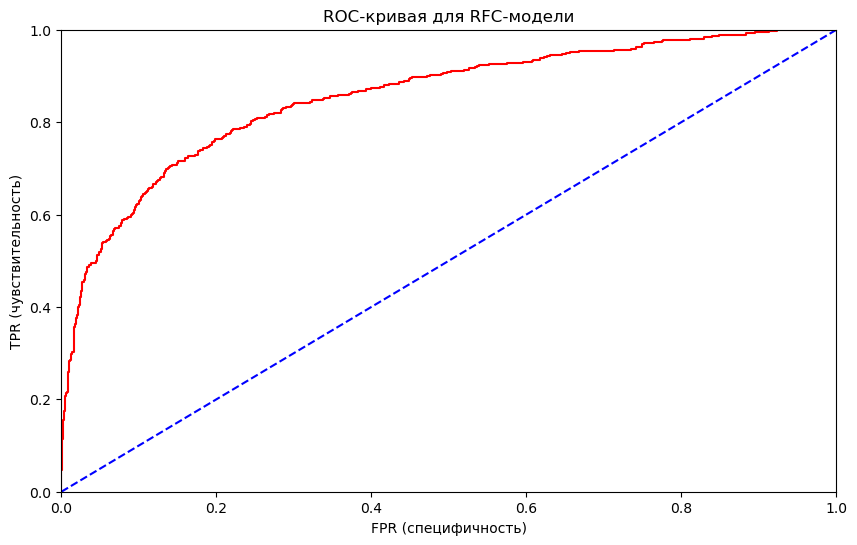

In [45]:
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR (специфичность)')
plt.ylabel('TPR (чувствительность)')
plt.title('ROC-кривая для RFC-модели');

Показатель AUC-ROC в 0,854 указывает на то, что итоговая RFC-модель имеет высокую чувствительность (TPR) и низкую специфичность (FPR).

###  Сравнение с константной моделью

Итоговая модель:

In [46]:
RFC_predictions = RFC_model_us.predict(features_test)
metrics(target_test, RFC_predictions)

Матрица ошибок:
 [[1350  227]
 [ 132  291]]
Точность: 0.5617760617760618
Полнота: 0.6879432624113475
F1-мера: 0.6184909670563231


Константная модель:

In [47]:
dummy_model_1 = DummyClassifier(strategy='constant', constant=1)
dummy_model_1.fit(features_train, target_train)
metrics(target_test, dummy_model_1.predict(features_test))

Матрица ошибок:
 [[   0 1577]
 [   0  423]]
Точность: 0.2115
Полнота: 1.0
F1-мера: 0.3491539413949649


В итоге работы у нас получилось создать модель, которая лучше предсказывает результат по всем метрикам.

# Выводы

В данном исследовании стояла задача построить качественную модель для прогнозирования ухода клиентов из «Бета-Банка» с показателем F1-меры не менее 0,59.

Для достижения максимально возможного значения, мы проанализировали несколько вариантов:

* Модели **дерева решений** и **линейной регрессии** не показали себя достаточно эффективными. Ни одна из них не достигла требуемого значения F1-меры.

* Модель **случайного леса** оказалась наиболее сбалансированной и близкой к критерям, обозначенных в задаче.

**Гиперпараметры итоговой RFC-модели**
* Количество деревьев — 97
* Глубина — 9

Для корректного воспроизведения модели необходимо провести **OHE** для категориальных признаков на всех выборках. Подготовку тренировочной выборки нужно производить методом **апсэмплинга**.

**Метрики на тестовой выборке**
* Точность — 0.5626204238921002
* Полнота — 0.6903073286052009
* F1-мера — 0.6199575371549895


Таким образом, цель исследования достигнута. Модель готова к внедрению 👍